In [222]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import collections

from operator import itemgetter
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [385]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_sample = df_train.sample(n=50000, replace=False)
train, test = train_test_split(df_sample, test_size = 0.2)

In [336]:
train.sort("gap", ascending=1).smiles[0:100].tolist()

['c1[SiH2]c(cc1)-c1sc(-c2sc(-c3cncc4nsnc34)c3[nH]ccc23)c2[nH]ccc12',
 'c1ccc(s1)-c1ncc(-c2sc(-c3scc4nccnc34)c3cc[nH]c23)c2nsnc12',
 'c1sc(-c2sc(-c3cnc(-c4scc5occc45)c4nsnc34)c3[nH]ccc23)c2ccoc12',
 'c1ccc(o1)-c1sc(-c2sc(-c3cncc4nsnc34)c3[nH]ccc23)c2cc[nH]c12',
 'c1sc(-c2sc(-c3cnc(-c4scc5occc45)c4nsnc34)c3[nH]ccc23)c2occc12',
 'C1=Cc2c(C1)c1c(c3CC(=Cc3c3=C[SiH2]C=c13)c1cncc3nsnc13)c1=C[SiH2]C=c21',
 'c1[SiH2]c(cc1)-c1sc(-c2ncc(-c3scc4cc[nH]c34)c3nsnc23)c2cc[nH]c12',
 '[nH]1cccc1-c1ncc(-c2sc(-c3ccc[se]3)c3cc[nH]c23)c2nsnc12',
 'c1[SiH2]c(cc1)-c1sc(-c2cnc(-c3scc4ccsc34)c3nsnc23)c2[nH]ccc12',
 'c1Cc(cc1)-c1sc(-c2sc(-c3Cccc3)c3[nH]ccc23)c2nccnc12',
 'c1ccc(o1)-c1ncc(-c2sc(-c3scc4nccnc34)c3cc[nH]c23)c2nsnc12',
 'c1ccc([se]1)-c1ncc(-c2sc(-c3scc4[nH]ccc34)c3[nH]ccc23)c2nsnc12',
 'c1sc(-c2sc(-c3sc(-c4scc5occc45)c4[nH]ccc34)c3nccnc23)c2cc[nH]c12',
 'c1sc(-c2cnc(-c3[SiH2]c(cc3)-c3scc4[nH]ccc34)c3nsnc23)c2[nH]ccc12',
 'c1Cc(cc1)-c1sc(-c2cnc(-c3scc4[nH]ccc34)c3nsnc23)c2cc[nH]c12',
 'c1ccc(o1)-c1sc(

In [326]:
def substringPrevalence(regex, substring, train, test) :
    X_train = train.drop(['smiles','gap'], axis=1)
    Y_train = train['gap']
    
    X_test = test.drop(['smiles','gap'], axis=1)
    Y_test = test['gap']
    
    LR = LinearRegression()
    LR.fit(X_train, Y_train)
    LR_pred = LR.predict(X_test)
    
    print X_train.shape
    
    # position == 0 : anywhere in string
    # position == 1 : beginning 
    # position == 2 : end of string
    
    X_train[substring] = [int(bool(re.search(regex,smile))) for smile in train.smiles]
    X_test[substring] = [int(bool(re.search(regex,smile))) for smile in test.smiles]
    
    print X_train.shape

    plt.scatter(rand_jitter(X_train[substring].tolist()),
                Y_train.tolist(),
                alpha=0.008)
    plt.xlabel('Presence of substring')
    plt.ylabel('Value of HOMO/LUMO gap')
    plt.title(substring + " substring in SMILE")
    
    LR_feature = LinearRegression()
    LR_feature.fit(X_train, Y_train)
    LR_pred_feature = LR_feature.predict(X_test)
    
    print "Sum of square residuals (linear regression)"
    print "With substring feature: " + str(np.sum([(pair[1] - pair[0])**2 for pair in zip(LR_pred_feature, Y_test)]))
    print "Without substring feature: " + str(np.sum([(pair[1] - pair[0])**2 for pair in zip(LR_pred, Y_test)]))

(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 778.000456114
Without substring feature: 887.063533025


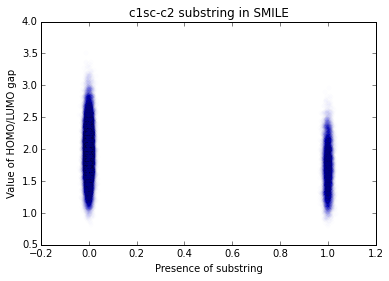

In [327]:
substringPrevalence('c1sc\(\-c2', 'c1sc-c2', train, test)

(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 857.94535012
Without substring feature: 887.063533025


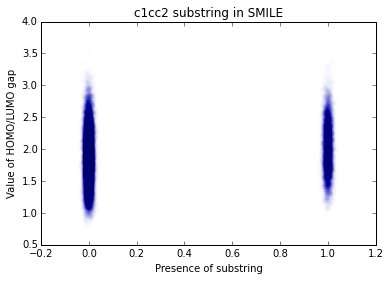

In [328]:
substringPrevalence('c1cc2', 'c1cc2', train, test)

(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 819.755045588
Without substring feature: 887.063533025


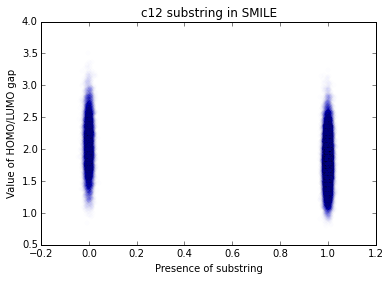

In [329]:
substringPrevalence('c12$', 'c12', train, test)

(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 821.907002633
Without substring feature: 887.063533025


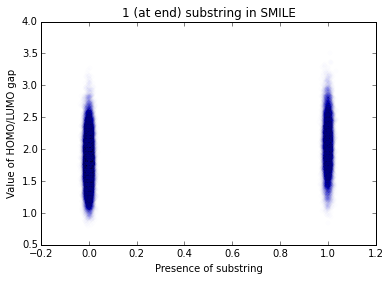

In [330]:
substringPrevalence('1$', '1 (at end)', train, test)

(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 862.381113837
Without substring feature: 887.063533025


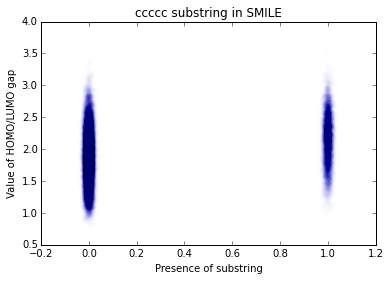

In [331]:
substringPrevalence('ccccc', 'ccccc', train, test)

(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 837.731442878
Without substring feature: 887.063533025


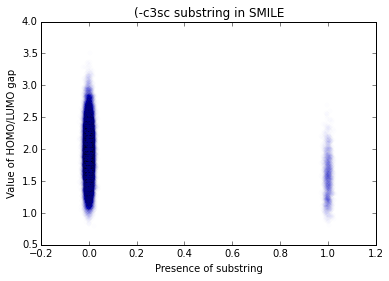

In [338]:
substringPrevalence('\(\-c3sc', '(-c3sc', train, test)

In [303]:
def substringScanner(stringLength=5, ascending=0, topResults=10, endResults=100):
    # ascending = 0 gives largest gap values; ascending = 1 gives smallest gap values
    # stringLength scans strings of that length
    # topResults gives you that many top results from the scanning
    
    occurences = collections.defaultdict(int)
    for j in range(0,endResults) :
        for element in train.sort("gap", ascending=ascending).smiles[j:j+1].tolist() :
            for i in range(0,(len(element) - stringLength)) :
                occurences[element[0+i:stringLength+i]] += 1
                
    a = sorted(occurences.items(), key=itemgetter(1), reverse=True)[0:10]
    reverseOcurrences = dict.fromkeys([i[0] for i in a], 0)
    
    newOccurences = []
    for element in train.sort("gap", ascending=abs(ascending-1)).smiles[0:endResults].tolist() :
        for i in range(0,(len(element) - stringLength)) :
            newOccurences.append(element[0+i:stringLength+i])
    
    for key in reverseOcurrences.keys() :
        reverseOcurrences[key] = newOccurences.count(key)
        
    table = pd.DataFrame()
    table['substring'] = reverseOcurrences.keys()
    table['first'] = [i[1] for i in a]
    table['second'] = reverseOcurrences.values()
    table['difference'] = table['first'] - table['second']
    table = table.sort('difference', ascending=0)
        
    return table

In [323]:
substringScanner(stringLength=5, ascending=1, topResults=10, endResults=100)

,substring,first,second,difference
0,[nH]c,132,13,119
1,c1sc(,100,0,100
2,23)c2,89,1,88
4,c(-c2,87,2,85
3,c23)c,87,4,83
5,c(-c3,73,1,72
6,34)c3,72,0,72
8,sc(-c,68,0,68
7,c34)c,69,3,66
9,-c2sc,62,0,62


(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 753.552574687
Without substring feature: 887.063533025


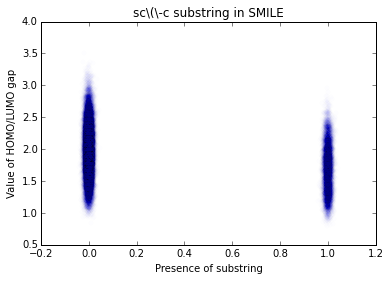

In [324]:
substringPrevalence('sc\(\-c', train, test)

(40000, 256)
(40000, 257)
Sum of square residuals (linear regression)
With substring feature: 722.3830768
Without substring feature: 887.063533025


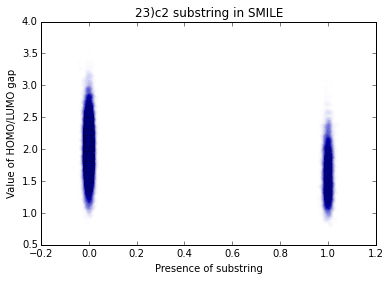

In [335]:
substringPrevalence('23\)c2', '23)c2', train, test)

In [395]:
def addFeature(regex, colname, df) :
    newdf = df.copy()
    newdf[colname] = [int(bool(re.search(regex, smile))) for smile in newdf.smiles]
    print "'" + colname + "' exists in " + str(np.sum(newdf[colname])) + " of the " + str(newdf.shape[0]) + " entries"
    print "New dimensions are: " + str(newdf.shape)
    print ""
    return newdf

In [396]:
df_updated = pd.DataFrame()
df_updated = addFeature('23\)c2', '23)c2', df_train)
df_updated = addFeature('sc\(\-c', 'sc(-c', df_updated)
df_updated = addFeature('\(\-c3sc', '(-c3sc', df_updated)
df_updated = addFeature('ccccc', 'ccccc', df_updated)
df_updated = addFeature('1$', '1_end', df_updated)
df_updated = addFeature('c12$', 'c12', df_updated)
df_updated = addFeature('c1cc2', 'c1cc2', df_updated)
df_updated = addFeature('c1sc\(\-c2', 'c1sc-c2', df_updated)

'23)c2' exists in 228330 of the 1000000 entries
New dimensions are: (1000000, 259)

'sc(-c' exists in 227935 of the 1000000 entries
New dimensions are: (1000000, 260)

'(-c3sc' exists in 43147 of the 1000000 entries
New dimensions are: (1000000, 261)

'ccccc' exists in 190569 of the 1000000 entries
New dimensions are: (1000000, 262)

'1_end' exists in 343511 of the 1000000 entries
New dimensions are: (1000000, 263)

'c12' exists in 654663 of the 1000000 entries
New dimensions are: (1000000, 264)

'c1cc2' exists in 263369 of the 1000000 entries
New dimensions are: (1000000, 265)

'c1sc-c2' exists in 209351 of the 1000000 entries
New dimensions are: (1000000, 266)



In [415]:
X_train, X_test = train_test_split(df_updated, test_size = 0.2)

Y_train = X_train['gap']
X_train = X_train.drop(['smiles','gap'], axis=1)
X_train_nofeat = X_train[[col for col in X_train.columns if 'feat' in col]]

Y_test = X_test['gap']
X_test = X_test.drop(['smiles','gap'], axis=1)
X_test_nofeat = X_test[[col for col in X_train.columns if 'feat' in col]]

LR = LinearRegression()
LR.fit(X_train_nofeat, Y_train)
LR_pred = LR.predict(X_test_nofeat)

LR_feat = LinearRegression()
LR_feat.fit(X_train, Y_train)
LR_feat_pred = LR_feat.predict(X_test)

print "Sum of square residuals (linear regression)"
print "No feature engineering: " + str(np.sum([(pair[1] - pair[0])**2 for pair in zip(LR_pred, Y_test)]))
print "With ALL substring feature: " + str(np.sum([(pair[1] - pair[0])**2 for pair in zip(LR_feat_pred, Y_test)]))

Sum of square residuals (linear regression)
No feature engineering: 17777.7996727
With ALL substring feature: 13196.4900599


In [ ]:
df_updated.to_pickle('df_updated.pkl')